In [1]:
import numpy as np
import copy as cp
import time

# Simulated Annealing

Solve the Sudoku problem with Simulated Annealing. You can design your own algorithm or simply refer to [Metaheuristics_can_solve_Sudoku_puzzles](https://www.researchgate.net/publication/220403361_Metaheuristics_can_solve_Sudoku_puzzles). 

The code provided below starts with making a problem instance and ends by visualizing the running process of SA.

In [2]:
# making a problem instance
def make_grid_python(n):
    grid = np.empty((n**2, n**2), int)
    x = 0
    for i in range(n):
        for j in range(n):
            for k in range(n**2):
                grid[n*i+j, k] = x%(n**2) + 1
                x += 1
            x += n+1
        x += 1
    return grid

def make_grid_numpy(n):
    return np.fromfunction(lambda i, j: (i*n+i//n+j)%(n**2)+1, (n**2, n**2), dtype=int)

# a comparison between native python and numpy
# vary n to see their performances
n = 10
%timeit make_grid_python(n)
%timeit make_grid_numpy(n)

# test
grid = make_grid_numpy(3)
grid

3.8 ms ± 69.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
109 µs ± 637 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
       [4, 5, 6, 7, 8, 9, 1, 2, 3],
       [7, 8, 9, 1, 2, 3, 4, 5, 6],
       [2, 3, 4, 5, 6, 7, 8, 9, 1],
       [5, 6, 7, 8, 9, 1, 2, 3, 4],
       [8, 9, 1, 2, 3, 4, 5, 6, 7],
       [3, 4, 5, 6, 7, 8, 9, 1, 2],
       [6, 7, 8, 9, 1, 2, 3, 4, 5],
       [9, 1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)

In [3]:
class Sudoku:
    @classmethod
    def create(cls, n, seed=303):
        rng = np.random.default_rng(seed)
        init_grid = make_grid_numpy(n)
        mask = rng.integers(0, 2, size=init_grid.shape)
        grid = init_grid * mask
        return cls(n, mask, grid, seed)

    def __init__(self, n, mask, grid, seed) -> None:
        self.seed = seed
        self.mask = mask
        self.grid = grid
        self.prev = grid
        self.n = n
        self.all = set(range(1, n**2+1))

    def value(self):
        final_value = 0
        for num in range(1, self.n**2+1):
            for i in range(self.n**2):
                cnt_col = 0
                cnt_row = 0
                for j in range(self.n**2):
                    if self.grid[i][j] == num:
                        cnt_row += 1
                    if self.grid[j][i] == num:
                        cnt_col += 1
                if cnt_col == 0:
                    final_value += 1
                if cnt_row == 0:
                    final_value += 1
        return final_value
    
    def local_search(self):
        self.prev = cp.deepcopy(self.grid)
        n = self.n
        grid = self.grid.reshape(n, n, n, n).transpose(0, 2, 1, 3)
        mask = self.mask.reshape(n, n, n, n).transpose(0, 2, 1, 3)
        tar_block = np.random.randint(0, n, 2)
        while 1:
            tar_cell_1 = np.random.randint(0, n, 2)
            if mask[tuple(tar_block)][tuple(tar_cell_1)] == 0:
                break
        num_1 = grid[tuple(tar_block)][tuple(tar_cell_1)]
        while 1:
            tar_cell_2 = np.random.randint(0, n, 2)
            if mask[tuple(tar_block)][tuple(tar_cell_2)] == 1:
                continue
            num_2 = grid[tuple(tar_block)][tuple(tar_cell_2)]
            if num_1 == num_2:
                continue
            grid[tuple(tar_block)][tuple(tar_cell_1)] = num_2
            grid[tuple(tar_block)][tuple(tar_cell_2)] = num_1
            break
        grid.transpose(0, 2, 1, 3).reshape(n**2, n**2)
        return self


    def init_solution(self):
        rng = np.random.default_rng(self.seed)
        n = self.n
        grid = self.grid.reshape(n, n, n, n).transpose(0, 2, 1, 3)
        for I in np.ndindex(n, n):
            idx = grid[I]==0
            grid[I][idx] = rng.permutation(list(self.all-set(grid[I].flat)))
        return self
        
    def __repr__(self) -> str:
        return self.grid.__repr__()

# test
sudoku = Sudoku.create(3)
sudoku = sudoku.init_solution()
sudoku.value()
sudoku = sudoku.local_search()
sudoku.value()

33

In [4]:
def simulated_annealing(initial:Sudoku, schedule, halt, log_interval=200):
    state = initial.init_solution()
    t = 0           # time step
    T = schedule(t) # temperature
    f = [state.value()] # a recording of values
    min_value = float("inf")
    while not halt(T):
        T = schedule(t)
        new_state = state.local_search()
        new_value = new_state.value()
        diff_value = min_value - new_value
        if diff_value > 0:
            min_value = new_value
        else:
            possibility = np.exp(diff_value / T)
            dice = np.random.rand()
            if dice <= possibility:
                min_value = new_value
            else:
                new_state.grid = new_state.prev
        f.append(min_value)
        # update time and temperature
        if t % log_interval == 0:
            print(f"step {t}: T={T}, current_value={state.value()}")
        t += 1
        T = schedule(t)
    print(f"step {t}: T={T}, current_value={state.value()}")
    return state, f

In [19]:
import matplotlib.pyplot as plt

# define your own schedule and halt condition
# run the algorithm on different n with different settings
n = 4
solution, record = simulated_annealing(
    initial=Sudoku.create(n), 
    schedule=lambda t: 0.999**t, 
    halt=lambda T: T<1e-7
)
solution, solution.value()

step 0: T=1.0, current_value=125
step 200: T=0.8186488294786356, current_value=74
step 400: T=0.6701859060067401, current_value=70
step 600: T=0.5486469074854967, current_value=58
step 800: T=0.4491491486100751, current_value=41
step 1000: T=0.36769542477096373, current_value=38
step 1200: T=0.3010134290933991, current_value=34
step 1400: T=0.2464242913846615, current_value=26
step 1600: T=0.20173495769715533, current_value=25
step 1800: T=0.16515008698369826, current_value=24
step 2000: T=0.13519992539749945, current_value=22
step 2200: T=0.11068126067226176, current_value=21
step 2400: T=0.09060908449456684, current_value=19
step 2600: T=0.07417702096160793, current_value=13
step 2800: T=0.060724931384432544, current_value=11
step 3000: T=0.04971239399803616, current_value=11
step 3200: T=0.04069699315707305, current_value=10
step 3400: T=0.033316545811337896, current_value=10
step 3600: T=0.027274551230723105, current_value=8
step 3800: T=0.02232827943958655, current_value=8
step 40

(array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
        [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4],
        [ 9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8],
        [13, 14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 2,  3,  4,  5,  6,  7, 16,  9, 10, 11, 12, 13, 14, 15,  8,  1],
        [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5],
        [10, 11, 12, 13, 14, 15,  8,  1,  2,  3,  4,  5,  6,  7, 16,  9],
        [14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2],
        [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5,  6],
        [11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3],
        [ 8,  9, 10, 11, 12, 13, 14, 1

Text(0, 0.5, 'value')

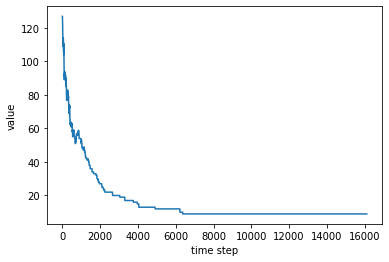

In [17]:
# visualize the curve
plt.plot(record)
plt.xlabel("time step")
plt.ylabel("value")